<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN-MANGROVE/blob/main/FASTER_RCNN_RESNET50_Mangrove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATASET

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("lampung-university-xfrhc").project("ekosistem-mangrove-hfgji")
version = project.version(23)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ekosistem-Mangrove-23 in voc:: 100%|██████████| 1418/1418 [00:00<00:00, 4181.43it/s]


In [ ]:
# Membuat folder images dan annotations
!mkdir -p images annotations

In [ ]:
import os
import shutil

# Daftar folder sumber
folders = ['/content/Ekosistem-Mangrove-23/train', '/content/Ekosistem-Mangrove-23/valid']

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

# Memindahkan file berdasarkan ekstensi
for folder in folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Memindahkan file .xml ke /content/annotations
        if filename.endswith('.xml'):
            shutil.move(file_path, '/content/annotations/')

        # Memindahkan file .png, .jpg, atau .jpeg ke /content/images
        elif filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.move(file_path, '/content/images/')

In [ ]:
import os
print(f"Jumlah file: {len([f for f in os.listdir('/content/annotations') if os.path.isfile(os.path.join('/content/annotations', f))])}")

Jumlah file: 707


In [ ]:
import os
import random
import numpy as np
import shutil

# Menghitung dan mencetak jumlah file di folder annotations dan images
print(f'Jumlah file di annotations: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images: {len(os.listdir("images"))}')

# Membuat folder test_images dan test_annotations
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Mengatur seed untuk reproducibility
random.seed(1234)

# Menghitung jumlah dataset
total_data = 707
test_data_count = int(0.11 * total_data)  # 11% dari total_data

# Mengambil indeks secara acak untuk 11% data
idx = random.sample(range(total_data), test_data_count)

# Memindahkan file gambar ke test_images
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move(os.path.join('images', img), os.path.join('test_images', img))

# Memindahkan file anotasi ke test_annotations
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move(os.path.join('annotations', annot), os.path.join('test_annotations', annot))

# Menghitung dan mencetak jumlah file setelah pemindahan
print(f'Jumlah file di annotations setelah pemindahan: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images setelah pemindahan: {len(os.listdir("images"))}')
print(f'Jumlah file di test_annotations: {len(os.listdir("test_annotations"))}')
print(f'Jumlah file di test_images: {len(os.listdir("test_images"))}')

Jumlah file di annotations: 707
Jumlah file di images: 707
Jumlah file di annotations setelah pemindahan: 630
Jumlah file di images setelah pemindahan: 630
Jumlah file di test_annotations: 77
Jumlah file di test_images: 77


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 1

# Fungsi untuk menghasilkan label sesuai dengan kelas
def generate_label(obj):
    if obj.find('name').text == "Mangrove":
        return 1 + adjust_label  # Mangrove
    elif obj.find('name').text == "Mangrove mati":
        return 2 + adjust_label  # Mangrove mati
    elif obj.find('name').text == "Non Mangrove":
        return 3 + adjust_label  # Non Mangrove
    return 0 + adjust_label

In [ ]:
# Fungsi untuk menghasilkan target (kotak dan label) dari file
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
# Fungsi untuk menampilkan gambar beserta kotak prediksi
def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1, 2, 0)  # Pindahkan ke CPU dan ubah urutan dimensi
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Loop melalui setiap kotak dan label
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # Warna kotak berdasarkan label
        if annotation['labels'][idx] == 1:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                     linewidth=1, edgecolor='g', facecolor='none')  # Mangrove (hijau)
        elif annotation['labels'][idx] == 2:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                     linewidth=1, edgecolor='r', facecolor='none')  # Mangrove mati (merah)
        elif annotation['labels'][idx] == 3:
            rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                     linewidth=1, edgecolor='orange', facecolor='none')  # Non Mangrove (Oranye)
        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

##LOAD MODEL AND TRAINING

In [ ]:
def get_model_instance_segmentation(num_classes, max_detections=1000):  # 1000 label
    # Pretrained Faster R-CNN with ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the head of the box predictor with custom number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Set the maximum number of detections per image (ubah default 100 ke max_detections)
    model.roi_heads.detections_per_img = max_detections

    return model

In [ ]:
# Instansiasi model dengan 4 kelas (Palm Tree + Background) dan set max 300 deteksi per gambar
model = get_model_instance_segmentation(4, max_detections=1000)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 15
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)

        # Filter annotations untuk hanya menyertakan box yang valid
        valid_annotations = []
        for t in annotations:
            # Hanya ambil bounding box yang valid
            valid_boxes = []
            for box in t['boxes']:
                # Pastikan box adalah tensor dan memiliki 4 elemen
                if isinstance(box, torch.Tensor) and box.numel() == 4:
                    x_min, y_min, x_max, y_max = box
                    if x_max > x_min and y_max > y_min:  # Pastikan lebar dan tinggi positif
                        valid_boxes.append(box)

            # Jika ada box yang valid, buat anotasi baru
            if valid_boxes:
                # Mengonversi valid_boxes menjadi tensor 2D
                try:
                    valid_boxes_tensor = torch.stack(valid_boxes).to(device)  # Gunakan stack jika valid_boxes adalah daftar tensor
                except Exception as e:
                    print(f'Error stacking valid boxes: {e}')
                    print(f'Valid boxes content: {valid_boxes}')
                    continue  # Lewati iterasi ini jika terjadi error

                # Update anotasi dengan valid boxes
                new_annotation = {k: v.to(device) if k != 'boxes' else valid_boxes_tensor for k, v in t.items()}
                valid_annotations.append(new_annotation)

        # Cek apakah jumlah gambar dan anotasi valid sama
        if valid_annotations and len(valid_annotations) == len(imgs):
            loss_dict = model(imgs, valid_annotations)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses
        else:
            print(f'Skipping batch {i}: {len(imgs)} images, {len(valid_annotations)} valid annotations.')

    print(f'epoch : {epoch + 1}, Loss : {epoch_loss}, time : {time.time() - start}')


----------------------train start--------------------------
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 1, Loss : 200.05709838867188, time : 135.7328314781189
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 2, Loss : 184.89320373535156, time : 135.9181399345398
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 3, Loss : 171.7867431640625, time : 135.82487058639526
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 4, Loss : 162.99151611328125, time : 135.4667797088623
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 5, Loss : 158.86741638183594, time : 136.26165437698364
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 6, Loss : 154.68600463867188, time : 136.64541625976562
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 7, Loss : 150.88426208496094, time : 136.52431201934814
Skipping batch 145: 4 images, 2 valid annotations.
epoch : 8, Loss : 145.3936004638672, time : 136.61878609657288
Skipping batch 145: 4 ima

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

##TEST AND EVALUATION

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[3.3573e+02, 8.0893e+01, 3.5847e+02, 1.2762e+02],
        [2.3311e+02, 1.0149e+02, 2.8251e+02, 1.6094e+02],
        [4.6516e+02, 1.0820e+02, 4.9364e+02, 1.5089e+02],
        [2.0883e+02, 4.8106e+01, 2.2643e+02, 7.7280e+01],
        [9.3726e+01, 1.6320e+01, 1.2314e+02, 5.3825e+01],
        [5.4656e+01, 8.9230e+01, 7.4669e+01, 1.1544e+02],
        [1.3601e+02, 2.3282e+01, 1.5921e+02, 6.1610e+01],
        [1.9428e+01, 1.1068e+02, 4.2543e+01, 1.3957e+02],
        [1.7592e+02, 2.7419e+02, 2.0696e+02, 3.1161e+02],
        [1.6604e+02, 4.5217e-01, 2.0182e+02, 4.5074e+01],
        [1.5660e+02, 2.5483e+02, 1.7596e+02, 2.7863e+02],
        [6.1795e+02, 1.6988e+02, 6.3886e+02, 2.0839e+02],
        [1.9420e+02, 1.7718e+02, 2.3713e+02, 2.4573e+02],
        [3.4680e+02, 3.9636e+01, 3.7016e+02, 8.3043e+01],
        [1.6369e+02, 1.6116e+02, 1.7933e+02, 1.8620e+02],
        [1.1589e+02, 2.0232e+00, 1.4005e+02, 3.0280e+01],
        [3.8154e+02, 1.6286e+01, 4.0416e+02, 5.7221e+01],
   

Target (Ground Truth):  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


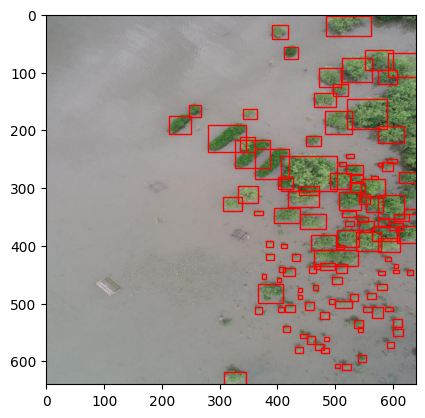

Prediction:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


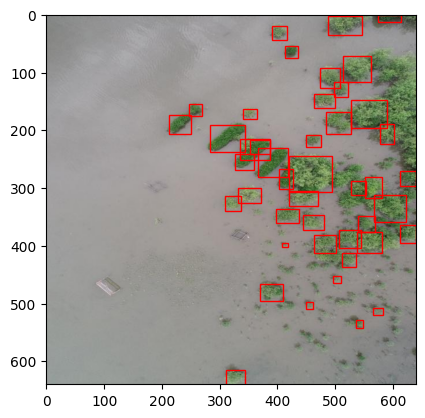

Jumlah label ground truth: 113
Jumlah label hasil prediksi: 44
Accuracy: 38.94%


In [ ]:
# GPU index untuk data yang digunakan
_idx = 1

# Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

# Pindahkan gambar ke CPU untuk visualisasi
imgs_cpu = imgs[_idx].cpu()

# Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()}

# Visualisasikan gambar dan anotasi (ground truth)
plot_image_from_output(imgs_cpu, annotations_cpu)

# Pindahkan prediksi ke CPU
pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()}

# Visualisasikan gambar dan prediksi
print("Prediction: ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)

# Hitung label ground truth dan prediksi
ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
predicted_labels = pred[_idx]['labels'].cpu().numpy()

# Jumlah label asli (ground truth) dan hasil prediksi
print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

# Menghitung akurasi dengan membagi jumlah label hasil prediksi dengan jumlah label ground truth
accuracy = len(predicted_labels) / len(ground_truth_labels) * 100 if len(ground_truth_labels) > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")



--- Visualisasi untuk Gambar 1 ---
Target (Ground Truth):  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


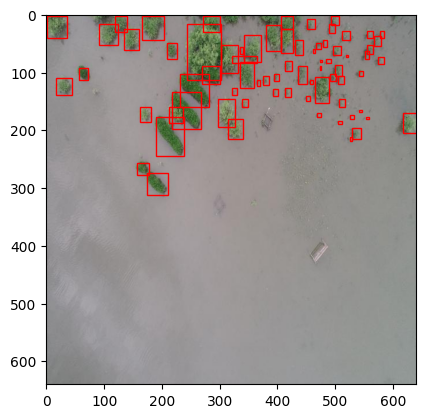

Prediction:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


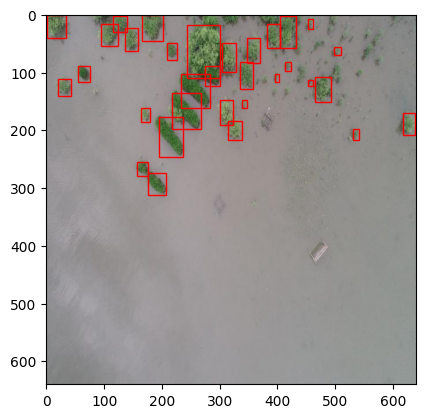

Jumlah label ground truth: 72
Jumlah label hasil prediksi: 32
Accuracy: 44.44%

--- Visualisasi untuk Gambar 2 ---
Target (Ground Truth):  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


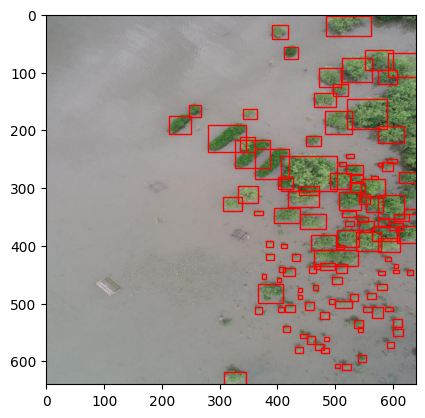

Prediction:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


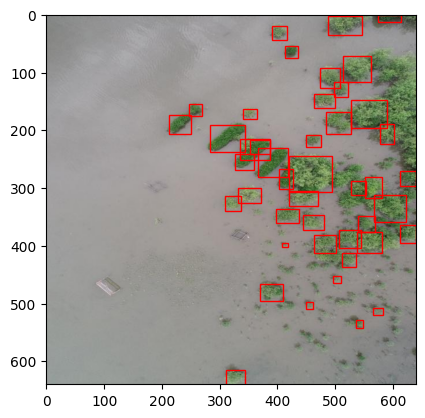

Jumlah label ground truth: 113
Jumlah label hasil prediksi: 44
Accuracy: 38.94%


In [ ]:
# Jumlah gambar yang ingin divisualisasikan
num_images = 2

# Dapatkan jumlah gambar yang ada dalam dataset
total_images = len(annotations)

# Iterasi hanya sampai jumlah gambar yang tersedia
for _idx in range(min(num_images, total_images)):
    print(f"\n--- Visualisasi untuk Gambar { _idx + 1} ---")

    # Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
    print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

    # Pindahkan gambar ke CPU untuk visualisasi
    imgs_cpu = imgs[_idx].cpu()

    # Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
    annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()}

    # Visualisasikan gambar dan anotasi (ground truth)
    plot_image_from_output(imgs_cpu, annotations_cpu)

    # Pindahkan prediksi ke CPU
    pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()}

    # Visualisasikan gambar dan prediksi
    print("Prediction: ", pred_cpu['labels'])
    plot_image_from_output(imgs_cpu, pred_cpu)

    # Hitung label ground truth dan prediksi
    ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
    predicted_labels = pred[_idx]['labels'].cpu().numpy()

    # Jumlah label asli (ground truth) dan hasil prediksi
    print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
    print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

    # Menghitung akurasi dengan membagi jumlah label hasil prediksi dengan jumlah label ground truth
    accuracy = len(predicted_labels) / len(ground_truth_labels) * 100 if len(ground_truth_labels) > 0 else 0
    print(f"Accuracy: {accuracy:.2f}%")

# Jika total_images < num_images, informasi ini dapat dicetak
if total_images < num_images:
    print(f"\nHanya ada {total_images} gambar dalam dataset, akurasi untuk gambar lebih dari itu tidak dapat dihitung.")


In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 39/39 [00:14<00:00,  2.70it/s]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 3.87 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!mv /content/Tutorial-Book-Utils/utils_ObjectDetection.py /content/

In [ ]:
import utils_ObjectDetection as utils

# Menghitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Output hasil evaluasi
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy.item()}')

Precision: tensor([0.7095, 0.7093])
Recall: tensor([0.5989, 0.6018])
F1-score: tensor([0.6495, 0.6511])
Accuracy: 0.7093023061752319


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5259814048287037
AP : tensor([0.5369, 0.5151], dtype=torch.float64)


In [ ]:
# Hitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections if total_detections > 0 else 0  # Akurasi = TP / (TP + FP)


# Menghitung Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE)
def calculate_mse_rmse(pred_scores, true_labels):
    """ Menghitung MSE dan RMSE """
    if len(pred_scores) != len(true_labels):
        raise ValueError("Jumlah prediksi dan jumlah label harus sama.")

    # Menghitung MSE
    mse = torch.mean((pred_scores - true_labels) ** 2)
    rmse = torch.sqrt(mse)

    return mse.item(), rmse.item()

# Filter pred_scores dan true_labels untuk memastikan ukurannya sama
valid_indices = true_positives.nonzero(as_tuple=True)[0]  # Ambil indeks True Positives

# Memastikan filtered_pred_scores dan filtered_true_labels memiliki ukuran yang sama
if len(valid_indices) > 0:
    filtered_pred_scores = pred_scores[valid_indices]

    # Ambil true labels yang sesuai dengan pred_labels
    filtered_true_labels = pred_labels[valid_indices]

    # Hitung MSE dan RMSE
    mse, rmse = calculate_mse_rmse(filtered_pred_scores, filtered_true_labels)

    # Output hasil MSE dan RMSE
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
else:
    print("Tidak ada True Positives yang ditemukan.")

Mean Squared Error (MSE): 1.199440360069275
Root Mean Squared Error (RMSE): 1.0951896905899048
